## Practica 2 Acuario

El dataset Acuario incorpora datos relacionados con varias especies de peces (tanto de agua dulce como de agua salada) y algunas de sus características. Este conjunto de datos está diseñado para poder conocer el peso de los distintos individuos de un acuario y poder alimentarlos en proporción a su peso.

El objetivo es usar algún estimador de  regresión para construir un modelo predictivo que pueda estimar el peso de un pez en función de su especie y lasmedidas físicas proporcionadas.

### Tipos de datos:

Especie - 0 a 6 cada número una especie.  
Peso - Columna objetivo, variable numérica medida en gramos.  
Long_vert - variable numérica medida en cm
Long_diag - variable numérica medida en cm  
Long_tras - variable numérica medida en cm  
Altura - variable numérica medida en cm  
Ancho - variable numérica medida en cm  

In [1]:
# Importamos las librerías necesarias para el proyecto
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Cargamos el dataset 
datos = pd.read_csv("acuario.csv")
# comprobamos que no haya ningún dato nulo
datos.isnull().sum()

Especie      0
Peso         0
Long_vert    0
Long_diag    0
Long_tras    0
Altura       0
Ancho        0
dtype: int64

In [3]:
# Exploración inicial de los datos
print("Primeras filas:")
print(datos.head())
print("Información del dataset:")
print(datos.info())
print("Estadísticas descriptivas:")
print(datos.describe())
# Vamos a ver cuantos peces de cada especie hay ya que es la columna que vamos a utilizar para estratificar los datos.
print("Distribución de especies:")
print(datos['Especie'].value_counts().sort_index())

Primeras filas:
   Especie   Peso  Long_vert  Long_diag  Long_tras   Altura   Ancho
0        0  242.0       23.2       25.4       30.0  11.5200  4.0200
1        0  290.0       24.0       26.3       31.2  12.4800  4.3056
2        0  340.0       23.9       26.5       31.1  12.3778  4.6961
3        0  363.0       26.3       29.0       33.5  12.7300  4.4555
4        0  430.0       26.5       29.0       34.0  12.4440  5.1340
Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Especie    159 non-null    int64  
 1   Peso       159 non-null    float64
 2   Long_vert  159 non-null    float64
 3   Long_diag  159 non-null    float64
 4   Long_tras  159 non-null    float64
 5   Altura     159 non-null    float64
 6   Ancho      159 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 8.8 KB
None
Estadísticas descriptivas:
     

In [4]:
# Gracias al método describe me ha saltado a la vista un peso mínimo de 0, dato que no concuerda. ningun pez puede pesar 0 gramos.
registro_peso_0 = datos[datos['Peso'] == 0]
print("Registro con peso 0:")
print(registro_peso_0)

Registro con peso 0:
    Especie  Peso  Long_vert  Long_diag  Long_tras  Altura   Ancho
40        2   0.0       19.0       20.5       22.8  6.4752  3.3516


In [5]:
# Entiendo que se trata de un error, así que voy a crear una copia del dataset sin ese registro para el proyecto.
# Crear una copia del dataset sin ningún pez que pese 0 gramos.
datos_limpios = datos[datos['Peso'] != 0].copy()

# Verificar
print("Dataset original: ", datos.shape)
print("Dataset limpio: ", datos_limpios.shape)
print("Peso mínimo en dataset limpio: ", datos_limpios['Peso'].min())

Dataset original:  (159, 7)
Dataset limpio:  (158, 7)
Peso mínimo en dataset limpio:  5.9


In [6]:
outliers_indices = []

# Lista de columnas numéricas (sin Especie)
columnas = ['Peso', 'Long_vert', 'Long_diag', 'Long_tras', 'Altura', 'Ancho']

# Para cada especie
for especie in datos_limpios['Especie'].unique():
    print(f"\n=== Especie {int(especie)} ===")
    
    # Filtrar datos de esta especie
    indices_especie = datos_limpios[datos_limpios['Especie'] == especie].index
    
    # Para cada variable
    for columna in columnas:
        datos_col = datos_limpios.loc[indices_especie, columna].values
        
        # Calcular límites
        Q1 = np.quantile(datos_col, 0.25)
        Q3 = np.quantile(datos_col, 0.75)
        IQR = Q3 - Q1
        k = 1.5
        xL = Q1 - k * IQR
        xU = Q3 + k * IQR
        
        # Detectar outliers
        for i in range(len(datos_col)):
            if datos_col[i] < xL or datos_col[i] > xU:
                indice_original = indices_especie[i]
                if indice_original not in outliers_indices:
                    print(f"{columna}: dato[{indice_original}] = {datos_col[i]} es outlier")
                    outliers_indices.append(indice_original)

print("Total de outliers encontrados: " ,len(outliers_indices))



=== Especie 0 ===
Long_vert: dato[34] = 38.0 es outlier

=== Especie 2 ===
Peso: dato[52] = 290.0 es outlier
Peso: dato[53] = 272.0 es outlier
Peso: dato[54] = 390.0 es outlier
Long_vert: dato[35] = 12.9 es outlier

=== Especie 6 ===

=== Especie 5 ===

=== Especie 1 ===

=== Especie 3 ===

=== Especie 4 ===
Peso: dato[157] = 19.7 es outlier
Peso: dato[158] = 19.9 es outlier
Total de outliers encontrados:  7


In [7]:
# Eliminar outliers
datos_finales = datos_limpios.drop(outliers_indices)

print("Dataset original:", datos_limpios.shape[0], "registros")
print("Outliers eliminados:", len(outliers_indices))
print("Dataset final:", datos_finales.shape[0], "registros")

Dataset original: 158 registros
Outliers eliminados: 7
Dataset final: 151 registros


In [8]:
# Establecemos una semilla aleatoria
np.random.seed(42)

# Vamos a estratificar el train split por especie y vamos a sacar la variable objetivo.
X = datos_finales.drop('Peso', axis=1)
y = datos_finales['Peso']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['Especie'])

print("Tamaño del conjunto de entrenamiento: ", len(X_train))
print("Tamaño del conjunto de test: ", len(X_test))
print("Distribución de especies en train:")
print(X_train['Especie'].value_counts().sort_index())
print("Distribución de especies en test:")
print(X_test['Especie'].value_counts().sort_index())

Tamaño del conjunto de entrenamiento:  120
Tamaño del conjunto de test:  31
Distribución de especies en train:
Especie
0    27
1    44
2    12
3    13
4    10
5     9
6     5
Name: count, dtype: int64
Distribución de especies en test:
Especie
0     7
1    12
2     3
3     4
4     2
5     2
6     1
Name: count, dtype: int64


In [9]:
#importamos el modelo de regresión linear.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

modelo_linear = LinearRegression()
resultados = cross_validate(modelo_linear, X, y, cv=3, 
                           return_train_score=True,
                           scoring='r2')

In [10]:
modelo_linear.fit(X_train, y_train)
print("Score en train:", modelo_linear.score(X_train, y_train))
print("Score en Test:", modelo_linear.score(X_test, y_test))
y_pred_test = modelo_linear.predict(X_test)


Score en train: 0.8828536462799941
Score en Test: 0.8961866098511311


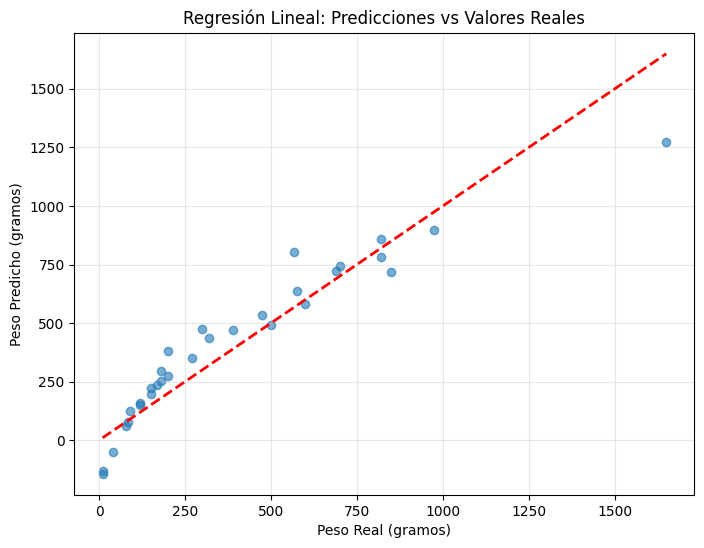

In [11]:
# Gráfico (convirtiendo a arrays para evitar problemas de índices)
plt.figure(figsize=(8, 6))
plt.scatter(y_test.values, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Peso Real (gramos)')
plt.ylabel('Peso Predicho (gramos)')
plt.title('Regresión Lineal: Predicciones vs Valores Reales')
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Ahora vamos a probar el modelo de regresión polinómica
from sklearn.preprocessing import PolynomialFeatures

In [13]:
print("REGRESIÓN POLINÓMICA")

resultados = {}

#bucle para probar los distintos grados de polinomios
for grado in range(1, 11):
    fp = PolynomialFeatures(degree=grado)
    X_pol_train = fp.fit_transform(X_train)
    
    modelo = LinearRegression()
    
    # Hacer validación cruzada (5 folds)
    cv_resultados = cross_validate(modelo, X_pol_train, y_train, cv=5, scoring='r2', return_train_score=True)
    # Calcular la media de los 5 scores de validación (test_score)
    r2_media = cv_resultados['test_score'].mean()
    resultados[grado] = r2_media
    
    print("Grado", grado, "- R2 medio:", r2_media)

# Encontrar el grado con el R2 más alto
# max busca la clave (grado) con el valor (R2) más alto y con get cogemos la clave con el valor más alto.
mejor_grado = max(resultados, key=resultados.get)
print("Mejor grado:", mejor_grado, "con R2:", resultados[mejor_grado])

fp_final = PolynomialFeatures(degree=mejor_grado)
X_pol_train_final = fp_final.fit_transform(X_train)
X_pol_test_final = fp_final.transform(X_test)

modelo_final = LinearRegression()
modelo_final.fit(X_pol_train_final, y_train)

print("R2 en test:", modelo_final.score(X_pol_test_final, y_test))

REGRESIÓN POLINÓMICA
Grado 1 - R2 medio: 0.8585642703478131
Grado 2 - R2 medio: 0.9576591273433099
Grado 3 - R2 medio: -1.0487714427838022
Grado 4 - R2 medio: -111.33773620844696
Grado 5 - R2 medio: -275.5275687465638
Grado 6 - R2 medio: -898.8210859040364
Grado 7 - R2 medio: -3188.9444960989285
Grado 8 - R2 medio: -11654.234554479914
Grado 9 - R2 medio: -44176.71359820747
Grado 10 - R2 medio: -168033.8691952552
Mejor grado: 2 con R2: 0.9576591273433099
R2 en test: 0.9675373833985229


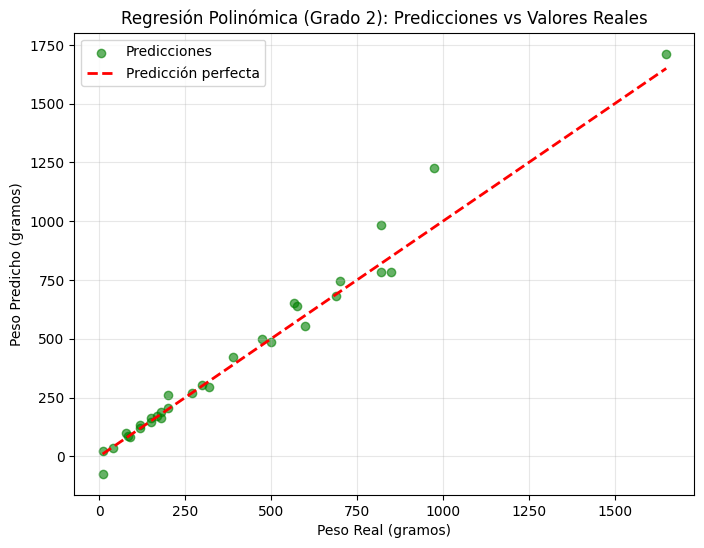

In [14]:
# Predicciones del modelo polinómico
y_pred_test_poly = modelo_final.predict(X_pol_test_final)

# Gráfico
plt.figure(figsize=(8, 6))
plt.scatter(y_test.values, y_pred_test_poly, alpha=0.6, color='green', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Predicción perfecta')
plt.xlabel('Peso Real (gramos)')
plt.ylabel('Peso Predicho (gramos)')
plt.title('Regresión Polinómica (Grado ' + str(mejor_grado) + '): Predicciones vs Valores Reales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
#Grid search con chatgpt.
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

print("=== SVM - GRID SEARCH ===")

# Semilla aleatoria
np.random.seed(42)

# Modelo
modelo_svm = SVR()

# Hiperparámetros a probar
parametros = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto', 0.1]
}

# Grid Search (hace la búsqueda automáticamente)
busqueda_grid = GridSearchCV(
    modelo_svm,
    parametros,
    cv=3,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

# Buscar mejores hiperparámetros
busqueda_grid.fit(X_train, y_train)

# Resultados
mejores_parametros = busqueda_grid.best_params_
mejor_score_validacion = busqueda_grid.best_score_
score_test = busqueda_grid.score(X_test, y_test)

print("\nMejor score validación:", mejor_score_validacion)
print("Mejores hiperparámetros:", mejores_parametros)
print("Score test:", score_test)

=== SVM - GRID SEARCH ===
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Mejor score validación: 0.9739938667809489
Mejores hiperparámetros: {'C': 0.1, 'epsilon': 1, 'gamma': 0.1, 'kernel': 'poly'}
Score test: 0.9532560167902422


In [28]:
#Grid search con los apuntes y las transparencias.
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

np.random.seed(42)

X_train_aux, X_val, y_train_aux, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=X_train['Especie']
)

modelo = SVR()

param_grid = {
    'kernel': ['poly', 'rbf'],  
    'degree': [2],
    'C': [0.1, 1, 10],
    'epsilon': [1, 10],
    'gamma': [0.01, 0.1, 1]
}

gs = GridSearchCV(modelo, param_grid, cv=3, verbose=2)

gs.fit(X_train_aux, y_train_aux)

score_test = gs.score(X_test, y_test)

print("Mejor puntuación en validacion cruzada: ", gs.best_score_)
print("Mejores hiperparametros encontrados:", gs.best_params_)
print("R2 en conjunto de test (evaluacion final sobre X_test):", score_test)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END C=0.1, degree=2, epsilon=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=0.1, degree=2, epsilon=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=0.1, degree=2, epsilon=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .C=0.1, degree=2, epsilon=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, degree=2, epsilon=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, degree=2, epsilon=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, degree=2, epsilon=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .C=0.1, degree=2, epsilon=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .C=0.1, degree=2, epsilon=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..C=0.1, degree=2, epsilon=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, degree=2, epsilon=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, degree=2, epsilon=1, gamma=0.

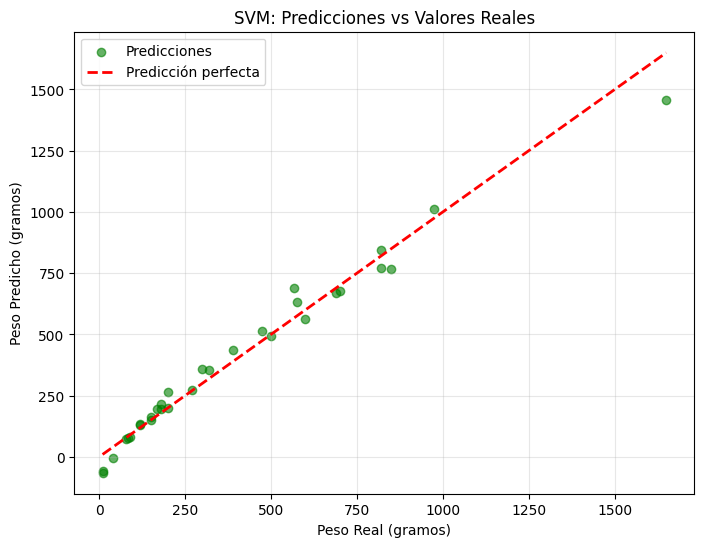

In [ ]:
# Entrenar modelo final SVM con mejores parámetros
modelo_final_svm = SVR(**gs.best_params_)
modelo_final_svm.fit(X_train, y_train)

# Predicciones (usa modelo_final_svm, NO modelo_final)
y_pred_test_svm = modelo_final_svm.predict(X_test)

# Gráfico
plt.figure(figsize=(8, 6))
plt.scatter(y_test.values, y_pred_test_svm, alpha=0.6, color='green', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Predicción perfecta')
plt.xlabel('Peso Real (gramos)')
plt.ylabel('Peso Predicho (gramos)')
plt.title('SVR: Predicciones vs Valores Reales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [32]:
print("="*60)
print("COMPARACIÓN FINAL DE MODELOS")
print("="*60)

# Regresión Lineal
print("1. REGRESIÓN LINEAL")
print("   Test:", modelo_linear.score(X_test, y_test))

# Regresión Polinómica
print("2. REGRESIÓN POLINÓMICA (Grado", mejor_grado, ")")
print("   Test:", modelo_final.score(X_pol_test_final, y_test))

# SVM
print("3. SVM")
print("   Mejores parámetros:", gs.best_params_)
print("   Test:", score_test)

# Determinar el mejor modelo
lineal = modelo_linear.score(X_test, y_test)
polinomico = modelo_final.score(X_pol_test_final, y_test)
svm = score_test

print("\n" + "="*60)
if lineal > polinomico and lineal > svm:
    print("MEJOR MODELO: REGRESIÓN LINEAL con =", lineal)
elif polinomico > lineal and polinomico > svm:
    print("MEJOR MODELO: REGRESIÓN POLINÓMICA (Grado", mejor_grado, ") con =", polinomico)
else:
    print("MEJOR MODELO: SVM con =", svm)
print("="*60)

COMPARACIÓN FINAL DE MODELOS
1. REGRESIÓN LINEAL
   Test: 0.8961866098511311
2. REGRESIÓN POLINÓMICA (Grado 2 )
   Test: 0.9675373833985229
3. SVM
   Mejores parámetros: {'C': 0.1, 'degree': 2, 'epsilon': 1, 'gamma': 0.1, 'kernel': 'poly'}
   Test: 0.9750387469443236

MEJOR MODELO: SVM con = 0.9750387469443236
